# Edited: Sama
# Spleen 3D CT Regression with MONAI



## Setup environment

In [65]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib


from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn

2023-12-21 05:34:29.059398: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 05:34:29.059445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 05:34:29.060814: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 05:34:30.251067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Set dataset path

In [66]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = '/content/drive/My Drive/MONAI_data'
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
os.makedirs(root_dir, exist_ok=True)
compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
# Create data dictionaries
data_dicts = [{"image": img, "target": img} for img in train_images]
# making  smaller input to save time for practing stage:
train_files, val_files = data_dicts[-9:], data_dicts[-9:]

set_determinism(seed=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
from monai.transforms import LoadImage

# Function to load an image and print its size
def print_image_size(file_info):
    loader = LoadImage(image_only=True)
    image = loader(file_info['image'])
    print(f"Image size: {image.shape}")

# Print sizes of the last few images in the train_files
print("Train Files:")
for file_info in train_files:  # Adjust the number as needed
    print_image_size(file_info)

# # Print sizes of the last few images in the val_files
# print("\nValidation Files:")
# for file_info in val_files:  # Adjust the number as needed
#     print_image_size(file_info)


Train Files:
Image size: torch.Size([512, 512, 33])
Image size: torch.Size([512, 512, 50])
Image size: torch.Size([512, 512, 135])
Image size: torch.Size([512, 512, 97])
Image size: torch.Size([512, 512, 101])
Image size: torch.Size([512, 512, 80])
Image size: torch.Size([512, 512, 60])
Image size: torch.Size([512, 512, 31])
Image size: torch.Size([512, 512, 41])


## Define CacheDataset and DataLoader

In [68]:
# import nibabel as nib

# def print_axial_pixel_size_nifti(file_path):
#     # Load the NIfTI file
#     nifti_img = nib.load(file_path)
#     header = nifti_img.header

#     # Extract pixel spacing (usually in the 'pixdim' field of the header)
#     # pixdim[1], pixdim[2], and pixdim[3] correspond to x, y, and z dimensions, respectively
#     spacing = header.get_zooms()
#     axial_spacing = spacing[:2]  # Get spacing for x and y dimensions (axial plane)
#     print(f"Image: {file_path}, Axial pixel size (x, y): {axial_spacing}")

# # Print axial pixel sizes for the first few images in train_files
# print("Axial Pixel Sizes in Training Data:")
# for file_info in train_files[:5]:  # Adjust the number as needed
#     file_path = file_info['image']
#     print_axial_pixel_size_nifti(file_path)


In [69]:
# #### My method

# crop_size = (512, 512, 16)  # Adjusted based on my data

# train_transforms = Compose(
#     [   LoadImaged(keys=["image", "target"]),
#         EnsureChannelFirstd(keys=["image", "target"]),
#         ScaleIntensityRanged(keys=["image", "target"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
#         Orientationd(keys=["image", "target"], axcodes="RAS"),
#         Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
#         Resized(keys=["image", "target"], spatial_size=crop_size, mode='bilinear'),
#         CenterSpatialCropd(keys=["image", "target"], roi_size=crop_size),
#         # RandCropByPosNegLabeld
#     ])

# val_transforms = Compose(
#     [   LoadImaged(keys=["image", "target"]),
#         EnsureChannelFirstd(keys=["image", "target"]),
#         ScaleIntensityRanged(keys=["image", "target"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
#         Orientationd(keys=["image", "target"], axcodes="RAS"),
#         Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
#         Resized(keys=["image", "target"], spatial_size=crop_size, mode=('bilinear')),
#         CenterSpatialCropd(keys=["image", "target"], roi_size=crop_size),

#     ])

# train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=2)
# train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)

# val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
# val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)



In [70]:
### First method

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        ScaleIntensityRanged(
            keys=["image", "target"],
            a_min=-1024,
            a_max=2048,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "target"], source_key="image"),
        Orientationd(keys=["image", "target"], axcodes="RAS"),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "target"],
            label_key="target",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),

    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        ScaleIntensityRanged(
            keys=["image", "target"],
            a_min=-1024,
            a_max=2048,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "target"], source_key="image"),
        Orientationd(keys=["image", "target"], axcodes="RAS"),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=2)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)


Loading dataset: 100%|██████████| 9/9 [00:35<00:00,  3.94s/it]


In [71]:
# Load a few sample images from the train_loader and print their sizes
for i, batch_data in enumerate(train_loader):
    images = batch_data["image"]
    print(f"Batch {i} image size: {images.shape}")
    if i == 2:  # Adjust this to inspect more or fewer batches
        break


Batch 0 image size: torch.Size([16, 1, 96, 96, 96])
Batch 1 image size: torch.Size([16, 1, 96, 96, 96])
Batch 2 image size: torch.Size([4, 1, 96, 96, 96])


image shape: torch.Size([239, 239, 113]), target shape: torch.Size([239, 239, 113])


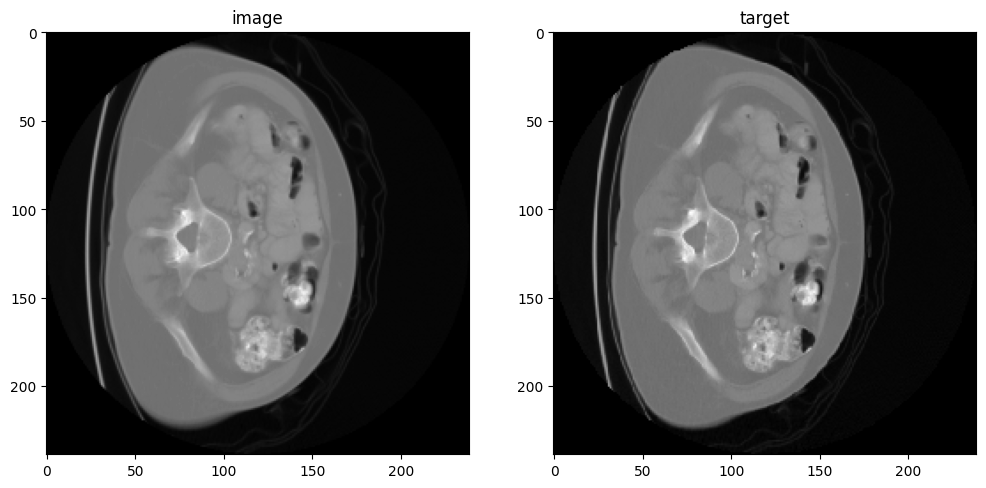

In [72]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, n]
n = 15
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, n], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target[:, :, n], cmap= "gray")
plt.show()

## Create Model, Loss, Optimizer

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64),
    act=(nn.ReLU, {"inplace": True}),
    strides=(2, 2),
  num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-6)
# from monai.networks.nets import BasicUNet
# model = BasicUNet(
#         spatial_dims=3,
#         in_channels=1,
#         out_channels=1,
#         features=(16, 32, 64, 128, 256, 16),  # Example feature sizes, adjust as needed
#         act=(nn.ReLU, {"inplace": True}),
# ).to(device)

# model = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=1,
#     channels=(16, 32, 64), # reducing the depth of the network and the number of channels in each convolutional layer
#     act=(nn.ReLU, {"inplace": True}),
#     strides=(2, 2), #  fewer downsampling and upsampling operations
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)
# loss_function = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), 1e-4)
# # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


## Execute a typical PyTorch training process

In [74]:
# ###### MY method
# max_epochs = 10
# val_interval = 2
# best_metric = float('inf')
# best_metric_epoch = -1
# epoch_loss_values = []
# metric_values = []

# for epoch in range(max_epochs):
#     print("-" * 10)
#     print(f"epoch {epoch + 1}/{max_epochs}")
#     model.train()
#     epoch_loss = 0
#     step = 0

#     for batch_data in train_loader:
#         step += 1
#         inputs, targets = (batch_data["image"].to(device),
#                            batch_data["target"].to(device),)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = loss_function(outputs, targets)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#         print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

#     epoch_loss /= step
#     epoch_loss_values.append(epoch_loss)
#     print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

#     if (epoch + 1) % val_interval == 0:
#         model.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for val_data in val_loader:
#                 val_inputs, val_targets = (val_data["image"].to(device),
#                                            val_data["target"].to(device),)
#                 val_outputs = model(val_inputs)
#                 val_loss += loss_function(val_outputs, val_targets).item()

#             val_loss /= len(val_loader)
#             metric_values.append(val_loss)
#             print(f"Validation loss: {val_loss:.4f}")

#             if val_loss < best_metric:
#                 best_metric = val_loss
#                 best_metric_epoch = epoch + 1
#                 torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
#                 print("Saved new best metric model")

# print(f"Training completed. Best validation loss: {best_metric:.4f} at epoch {best_metric_epoch}")


In [75]:
#### First method
max_epochs = 100
val_interval = 2
best_metric = float('inf')  # Initialize with infinity, since lower MSE is better
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, targets = (
            batch_data["image"].to(device),
            batch_data["target"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_targets = (
                    val_data["image"].to(device),
                    val_data["target"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                # Compute MSE for current iteration
                val_loss += loss_function(val_outputs, val_targets).item()

            val_loss /= len(val_loader)
            metric_values.append(val_loss)
            if val_loss < best_metric:
                best_metric = val_loss
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current val loss: {val_loss:.4f}"
                f"\nbest val loss: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )


----------
epoch 1/100
1/2, train_loss: 0.5304
2/2, train_loss: 0.5415
3/2, train_loss: 0.4864
epoch 1 average loss: 0.5195
----------
epoch 2/100
1/2, train_loss: 0.5288
2/2, train_loss: 0.5226
3/2, train_loss: 0.5409
epoch 2 average loss: 0.5308
saved new best metric model
current epoch: 2 current val loss: 0.0234
best val loss: 0.0234 at epoch: 2
----------
epoch 3/100
1/2, train_loss: 0.4824
2/2, train_loss: 0.5241
3/2, train_loss: 0.5862
epoch 3 average loss: 0.5309
----------
epoch 4/100
1/2, train_loss: 0.5122
2/2, train_loss: 0.5193
3/2, train_loss: 0.5160
epoch 4 average loss: 0.5158
current epoch: 4 current val loss: 0.0248
best val loss: 0.0234 at epoch: 2
----------
epoch 5/100
1/2, train_loss: 0.5081
2/2, train_loss: 0.4975
3/2, train_loss: 0.4768
epoch 5 average loss: 0.4941
----------
epoch 6/100
1/2, train_loss: 0.5080
2/2, train_loss: 0.4840
3/2, train_loss: 0.4319
epoch 6 average loss: 0.4746
current epoch: 6 current val loss: 0.0295
best val loss: 0.0234 at epoch: 2


## Plot the loss and metric

train completed, best_metric: 0.0234 at epoch: 2


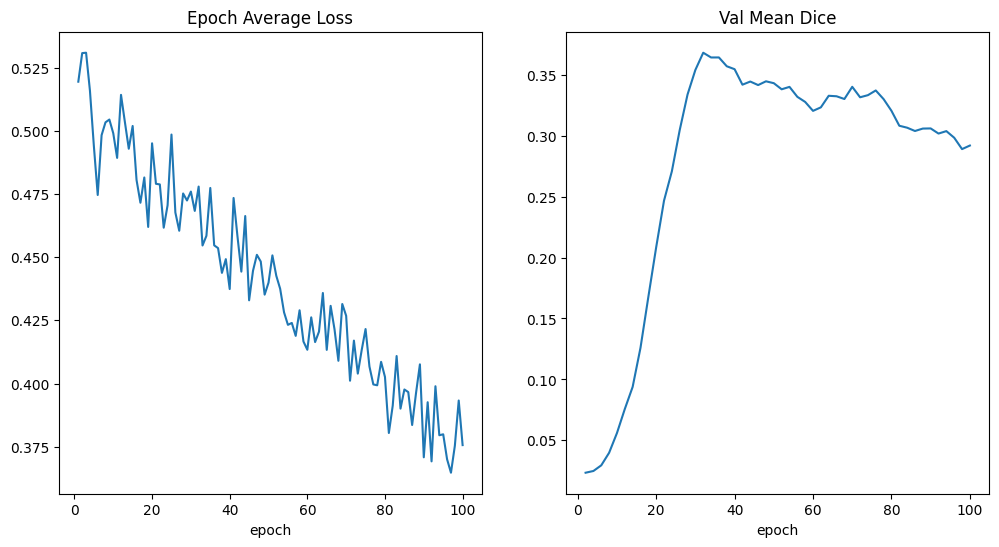

In [76]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

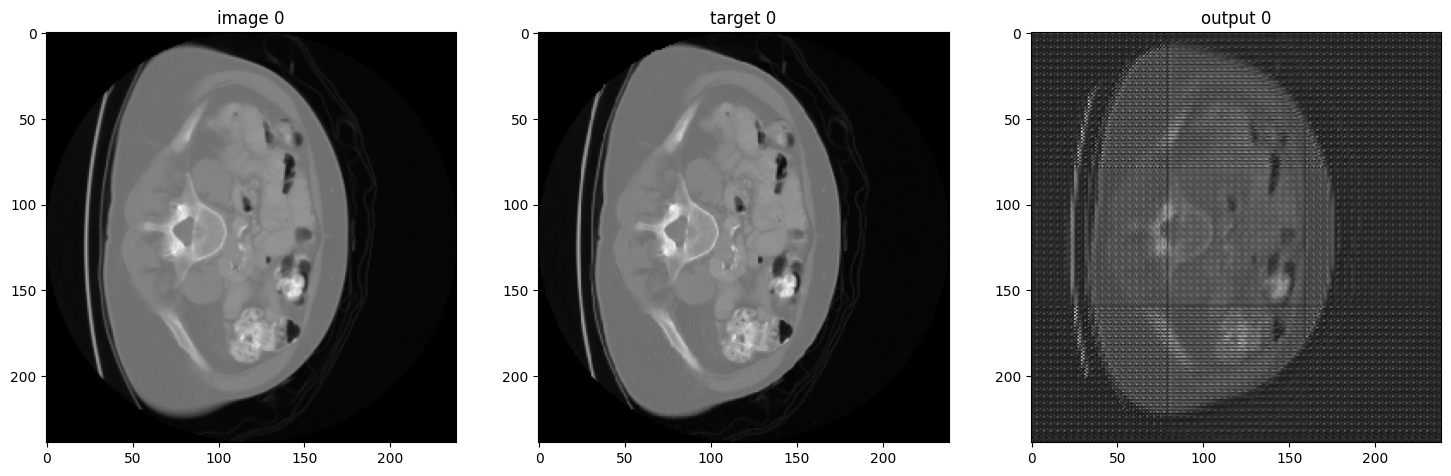

In [77]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)

        # plot the slice [:, :, n]
        n =15
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, n], cmap="gray")

        plt.subplot(1, 3, 2)
        plt.title(f"target {i}")
        plt.imshow(val_data["target"][0, 0, :, :, n], cmap="gray")

        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        output_slice = val_outputs.detach().cpu()[0, 0, :, :, n]
        plt.imshow(output_slice, cmap="gray")
        plt.show()
        if i == 0:
            break


In [78]:
# if directory is None:
#     shutil.rmtree(root_dir)

---------------------